In [14]:
import os
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import gmean


In [15]:
def list_files_with_extension(directory, extension):
    files_with_extension = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(extension):
                files_with_extension.append(os.path.join(root, file))
    return files_with_extension

# Example usage
base_dir = "../traces/SPEC-CPU2017/"
extension = '.champsimtrace.xz'  # Change this to your desired extension
files = list_files_with_extension(base_dir, extension)
for file in files:
    print(file)

../traces/SPEC-CPU2017/482.sphinx3-234B.champsimtrace.xz
../traces/SPEC-CPU2017/450.soplex-247B.champsimtrace.xz
../traces/SPEC-CPU2017/654.roms_s-1007B.champsimtrace.xz
../traces/SPEC-CPU2017/462.libquantum-714B.champsimtrace.xz
../traces/SPEC-CPU2017/471.omnetpp-188B.champsimtrace.xz
../traces/SPEC-CPU2017/619.lbm_s-2676B.champsimtrace.xz
../traces/SPEC-CPU2017/429.mcf-184B.champsimtrace.xz
../traces/SPEC-CPU2017/602.gcc_s-2226B.champsimtrace.xz
../traces/SPEC-CPU2017/623.xalancbmk_s-10B.champsimtrace.xz
../traces/SPEC-CPU2017/649.fotonik3d_s-10881B.champsimtrace.xz
../traces/SPEC-CPU2017/625.x264_s-12B.champsimtrace.xz
../traces/SPEC-CPU2017/436.cactusADM-1804B.champsimtrace.xz


In [16]:
base_dir = "../logs/SPEC-CPU/"
# Define trace names and configuration labels
trace_names = ['429.mcf-184B', '436.cactusADM-1804B', '450.soplex-247B', '462.libquantum-714B', 
'471.omnetpp-188B', '482.sphinx3-234B', '619.lbm_s-2676B', 
'623.xalancbmk_s-10B', '625.x264_s-12B', '649.fotonik3d_s-10881B', '654.roms_s-1007B']
configs = ['baseline', 'ipcp', 'ipcp-isb', 'isb']

# Initialize a dictionary to store IPC values for each trace and configuration
ipc_values = {trace: {} for trace in trace_names}


In [17]:
ipc_values

{'429.mcf-184B': {},
 '436.cactusADM-1804B': {},
 '450.soplex-247B': {},
 '462.libquantum-714B': {},
 '471.omnetpp-188B': {},
 '482.sphinx3-234B': {},
 '619.lbm_s-2676B': {},
 '623.xalancbmk_s-10B': {},
 '625.x264_s-12B': {},
 '649.fotonik3d_s-10881B': {},
 '654.roms_s-1007B': {}}

In [18]:
def extract_ipc(log_file):
    with open(log_file, 'r') as f:
        for line in f:
            if 'CPU 0 cumulative IPC' in line:  # Assuming the line with IPC contains the keyword 'IPC'
                ipc_value = float(re.search(r"IPC:\s([\d\.]+)", line).group(1))
                return ipc_value
    return None

# Parse the IPC values from the log files
for trace in trace_names:
    for config in configs:
        log_file = base_dir + f"{trace}-{config}.log"
        ipc_values[trace][config] = extract_ipc(log_file)


In [19]:
# Calculate speedups relative to the baseline
speedups = {trace: {} for trace in trace_names}

for trace in trace_names:
    baseline_ipc = ipc_values[trace]['baseline']
    for config in configs[1:]:  # Skip baseline
        speedups[trace][config] = ipc_values[trace][config] / baseline_ipc
# Calculate geometric mean for each configuration (excluding baseline)
geomeans = {}
for config in configs[1:]:
    config_speedups = [speedups[trace][config] for trace in trace_names]
    geomeans[config] = gmean(config_speedups)  # Use scipy's gmean for geometric mean

speedups['Geomean'] = geomeans
trace_names += ['Geomean']

In [20]:
speedups

{'429.mcf-184B': {'ipcp': 1.189947486871718,
  'ipcp-isb': 1.3329507134065068,
  'isb': 1.1059060881725284},
 '436.cactusADM-1804B': {'ipcp': 1.025911833237881,
  'ipcp-isb': 1.1986631414606592,
  'isb': 1.1820669527627627},
 '450.soplex-247B': {'ipcp': 1.3543471720818292,
  'ipcp-isb': 1.4133762033694344,
  'isb': 1.4130678399518652},
 '462.libquantum-714B': {'ipcp': 1.4574295591519566,
  'ipcp-isb': 1.4508163286117826,
  'isb': 1.4245418667971979},
 '471.omnetpp-188B': {'ipcp': 1.0313069383303854,
  'ipcp-isb': 1.2751614776591171,
  'isb': 1.3000802400996574},
 '482.sphinx3-234B': {'ipcp': 1.482130433935978,
  'ipcp-isb': 1.3658742536276394,
  'isb': 1.4092466086858002},
 '619.lbm_s-2676B': {'ipcp': 1.2439161283490416,
  'ipcp-isb': 1.1457040488545307,
  'isb': 1.0},
 '623.xalancbmk_s-10B': {'ipcp': 1.1042213761879034,
  'ipcp-isb': 1.3170199488191119,
  'isb': 1.2326845674126008},
 '625.x264_s-12B': {'ipcp': 1.0034413496355947,
  'ipcp-isb': 1.0026616328674227,
  'isb': 1.0001589378

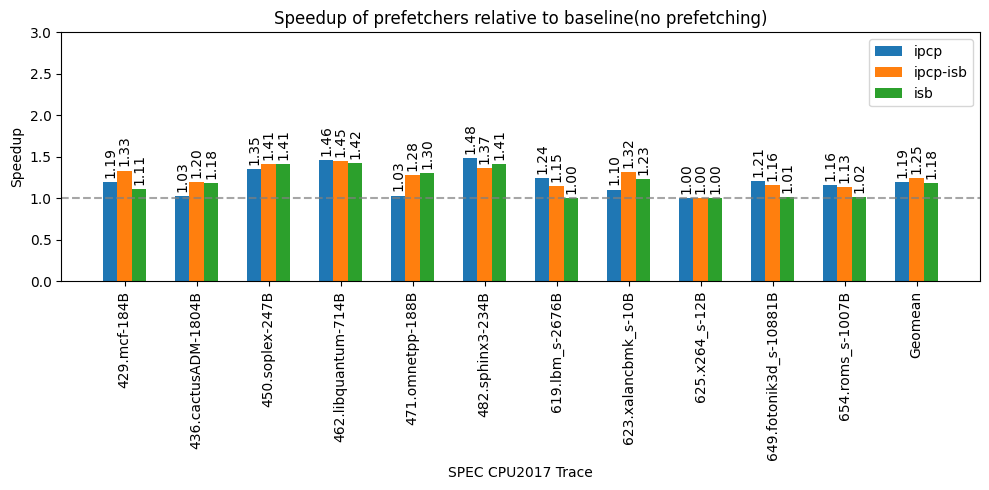

In [26]:
# Plotting the speedups
plt.rcParams.update({'font.size': 10})
x = np.arange(len(trace_names))  # X axis positions for the traces
width = 0.2  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 5))

# Plot bars for each configuration
for i, config in enumerate(configs[1:]):  # Skip baseline
    speedup_values = [speedups[trace][config] for trace in trace_names]
    bars = ax.bar(x + i*width, speedup_values, width, label=config)
    
    # Annotate bars with speedup values
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',  # Format the annotation to 2 decimal places
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text slightly above the bar
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=90)

# Add a translucent dashed line at y=1.0 for the baseline
ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)


# Add labels and titles
ax.set_xlabel('SPEC CPU2017 Trace')
ax.set_ylim(0, 3.0)
ax.set_ylabel('Speedup')
ax.set_title('Speedup of prefetchers relative to baseline(no prefetching)')
ax.set_xticks(x + 2*width / 2)
ax.set_xticklabels(trace_names, rotation=90)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()
